In [1]:
%matplotlib inline


Example 2: Analysis of ERA5 profiles
====================

Using hourly data from ERA5 (<strong>ea</strong>) model-level (<strong>ml</strong>) and surface (<strong>sfc</strong>) analyses (<strong>an</strong>).

This is for single-point profile data in <strong>.nc</strong> format - here the LAFE field campaign site at the DOE-ARM Southern Great Plains facility in Oklahoma.

Calculates thermodynamic variables, indices for profile, and L-A metrics.


In [2]:
from datetime import datetime

import sys
import math
import matplotlib.pyplot as plt
from metpy.plots import SkewT
from metpy.units import units
import metpy.calc as calc
import metpy.constants as c
#import metpy.interpolate as interp
import numpy as np
import pandas as pd # Gonna use dataframes to manage profile data
from netCDF4 import Dataset, date2index

Path to ERA5 data. 

Set requested time using a datetime object (in range of MJJAS 2011-2019).

In [3]:
epath = '/Users/dirmeyer/MyFiles/Data Sets/CLASP/SGP_hourly/'
dt = datetime(2017, 8, 19, 12) # YYYY, M, D, H(UTC) for "sounding"

# This is a table of the pseudo-levels for ERA5 model-level data 
plevels = pd.read_csv(epath+'ERA5_levels.csv') 
plevs = plevels.loc[::-1,'plevel'].tolist() * units.pascals
ptops = plevels.loc[::-1,'ptop'].tolist() * units.pascals
#print(ptops)

# Surface and model-level data files for indicated year
sfcfile = epath+'ea_an_sfc_lafe_'+str(dt.year)+'0501_'+str(dt.year)+'0930.nc'
fcfile = epath+'ea_fc_sfc_lafe_'+str(dt.year)+'0501_'+str(dt.year)+'0930.nc'
mlfile = epath+'ea_an_ml_lafe_'+str(dt.year)+'0501_'+str(dt.year)+'0930.nc'

Extract Data
----------------

NetCDF data files; <strong>sfc</strong> has only a time dimension that varies, although there are 1-D latitude and longitude dimensions.

The <strong>ml</strong> file has varying time and pseudo-pressure levels that need to be scaled by surface pressure (sp) to get real levels.

In [4]:
# MetPy does not define a constant for mean sea level pressure - why not?
mean_slp = 101325.0 * units.pascal

# Read sounding data based on time (dt)
sfcdata = Dataset(sfcfile,"r")
fcdata = Dataset(fcfile,"r")
mldata = Dataset(mlfile,"r")
#print (mldata)

# Find the time index for the requested date
all_times = mldata.variables['time']
dindex = date2index(dt,all_times)
#print(dindex)

# Standard sounding data 
ml_t = np.squeeze(mldata.variables["t"][dindex]) * units.kelvin
ml_u = np.squeeze(mldata.variables["u"][dindex]) * units.m / units.sec
ml_v = np.squeeze(mldata.variables["v"][dindex]) * units.m / units.sec
ml_q = np.squeeze(mldata.variables["q"][dindex]) * units.kg / units.kg

Calculate derived fields
---------------------------

Model levels convolved with plevels and surface pressure to get actual pressure.

In [5]:
sfc_p = np.squeeze(sfcdata.variables["sp"][dindex]) * units.pascal
ml_p = plevs * sfc_p / mean_slp
ml_top = ptops * sfc_p / mean_slp

Make profile of dew points, mixing ratios

In [6]:
ml_td = calc.dewpoint_from_specific_humidity(ml_q, ml_t, ml_p).to('kelvin')
ml_w = calc.mixing_ratio_from_specific_humidity(ml_q)

Make profiles of various potential temperatures

In [7]:
ml_pot = calc.potential_temperature(ml_p, ml_t)
ml_pote = calc.equivalent_potential_temperature(ml_p, ml_t, ml_td)
ml_potv = calc.virtual_potential_temperature(ml_p, ml_t, ml_q)

To make the stepwise calculations work, we have to add the surface pressure as an additional "level", then do the same for the other variables used.  This is because profile - based calculations must be bounded by profile levels at top and bottom to do the calculations (e.g., can't extrapolate from center of lowest model level to ground).

<u>Seems that the numpy <strong>append</strong> confounds MetPy unit handling - have to redeclare the units</u>

In [8]:
mls_p = np.append(ml_p,sfc_p) * units.pascal
#print(ml_p, ml_p[54])

# Tack on the other "surface" variables
sfc_t = np.squeeze(sfcdata.variables["t2m"][dindex]) * units.kelvin # Will use this again below
mls_t = np.append(ml_t,sfc_t) * units.kelvin
sfc_td = np.squeeze(sfcdata.variables["d2m"][dindex]) * units.kelvin # Will use this again below
mls_td = np.append(ml_td,sfc_td) * units.kelvin
mls_u = np.append(ml_u,np.squeeze(sfcdata.variables["u10"][dindex])) * units('m/s')
ml_v = np.append(ml_v,np.squeeze(sfcdata.variables["v10"][dindex])) * units('m/s')

# Gotta calcualte a surface mixing ratio
sfc_q = calc.specific_humidity_from_dewpoint(sfc_td,sfc_p)
sfc_w = calc.mixing_ratio_from_specific_humidity(sfc_q)
mls_w = np.append(ml_w,sfc_w) * units.kg / units.kg

More profile variables - these have to be built up from the bottom. Because extrapolation is forbidden, the top layer doesn't get a value.

In [9]:
# Create empty profiles of new variables to fill
#ml_thick = np.full_like(ml_p, np.nan) * units.meter
#ml_z = np.full_like(ml_p, np.nan) * units.meter
ml_thick = np.zeros_like(ml_p) * units.meter
ml_z = np.zeros_like(ml_p) * units.meter

bot_p = sfc_p 
for i in range(len(ml_p)-1):
    ii = len(ml_p) - i - 1
    top_p = ml_top[ii]
    mid_p = ml_p[ii]
    del_p = bot_p - top_p
    ml_thick[ii] = calc.thickness_hydrostatic(mls_p, mls_t, mixing=mls_w, bottom=bot_p, depth=del_p)
    ml_z[ii] = np.sum(ml_thick) - ml_thick[ii]/2.0 # Clever bit of summing to find z at middle of layer
#    print(bot_p,mid_p,top_p,ml_z[ii])
    bot_p = top_p
#print(ml_z)


Once we have the heights, we can calculate more profile variables

In [10]:
ml_mse = calc.moist_static_energy(ml_z, ml_t, ml_q)
ml_mse[0] = ml_mse[0] * 0.0

ml_parcel = calc.parcel_profile(np.flip(ml_p), sfc_t, sfc_td) # Note the flipping; goes from surface up.
#print(ml_parcel)
mls_parcel = calc.parcel_profile(np.flip(mls_p), sfc_t, sfc_td) # Note the flipping; goes from surface up.
#print(mls_parcel)

Lastly, single value (s_*) indices calculated from the profiles

In [11]:
# Some come in the surface analysis
"""
s_pbl_e = np.squeeze(sfcdata.variables["blh"][dindex]) * units.meter
s_cape_e = np.squeeze(sfcdata.variables["cape"][dindex]) * units.joule / units.kg
s_pw_e = np.squeeze(sfcdata.variables["tcw"][dindex]) * units.kg / units.meter / units.meter
s_tclw_e = np.squeeze(sfcdata.variables["tclw"][dindex]) * units.kg / units.meter / units.meter
s_tciw_e = np.squeeze(sfcdata.variables["tciw"][dindex]) * units.kg / units.meter / units.meter
s_pbl_f = np.squeeze(fcdata.variables["blh"][dindex]) * units.meter 
s_cape_f = np.squeeze(fcdata.variables["cape"][dindex]) * units.joule / units.kg
s_cin_f = np.squeeze(fcdata.variables["cin"][dindex]) * units.joule / units.kg
s_ustar_f = np.squeeze(fcdata.variables["zust"][dindex]) * units.meter / units.sec
s_cbh_f = np.squeeze(fcdata.variables["cbh"][dindex]) * units.meter 
s_sh_f = np.squeeze(fcdata.variables["msshf"][dindex]) * units.meter 
s_lh_f = np.squeeze(fcdata.variables["mslhf"][dindex]) * units.meter 
s_swd_f = np.squeeze(fcdata.variables["msdwswrf"][dindex]) * units.watt / units.meter / units.meter
s_lwd_f = np.squeeze(fcdata.variables["msdwlwrf"][dindex]) * units.watt / units.meter / units.meter
s_swn_f = np.squeeze(fcdata.variables["msnswrf"][dindex]) * units.watt / units.meter / units.meter
s_lwn_f = np.squeeze(fcdata.variables["msnlwrf"][dindex]) * units.watt / units.meter / units.meter
s_precip_f = np.squeeze(fcdata.variables["tp"][dindex]) * units.meter / units.hour
s_kx_f = np.squeeze(fcdata.variables["kx"][dindex]) * units.kelvin
s_ttx_f = np.squeeze(fcdata.variables["totalx"][dindex]) * units.kelvin
"""

# The rest we calculate
s_el_p, s_el_t = calc.el(mls_p, mls_t, mls_td, mls_parcel)
s_lcl_p, s_lcl_t = calc.lcl(sfc_p, sfc_t, sfc_td, max_iters=50, eps=1e-05)

s_lcl_z = (sfc_t - sfc_td) / c.dry_adiabatic_lapse_rate.to('K/m') + 2.0 * units.m
s_lfc = calc.lfc(mls_p, mls_t, mls_td)
s_cape, s_cin = calc.cape_cin(np.flip(mls_p), np.flip(mls_t), np.flip(mls_td), mls_parcel)
s_pw = calc.precipitable_water(mls_td, mls_p)

/Users/dirmeyer/miniconda3/envs/unidata/lib/python3.7/site-packages/metpy/interpolate/one_dimension.py:154: UserWarning: Interpolation point out of data bounds encountered
  warnings.warn('Interpolation point out of data bounds encountered')


Make Skew-T Plot
----------------

The code below makes a basic skew-T plot using the MetPy plot module
that contains a SkewT class.




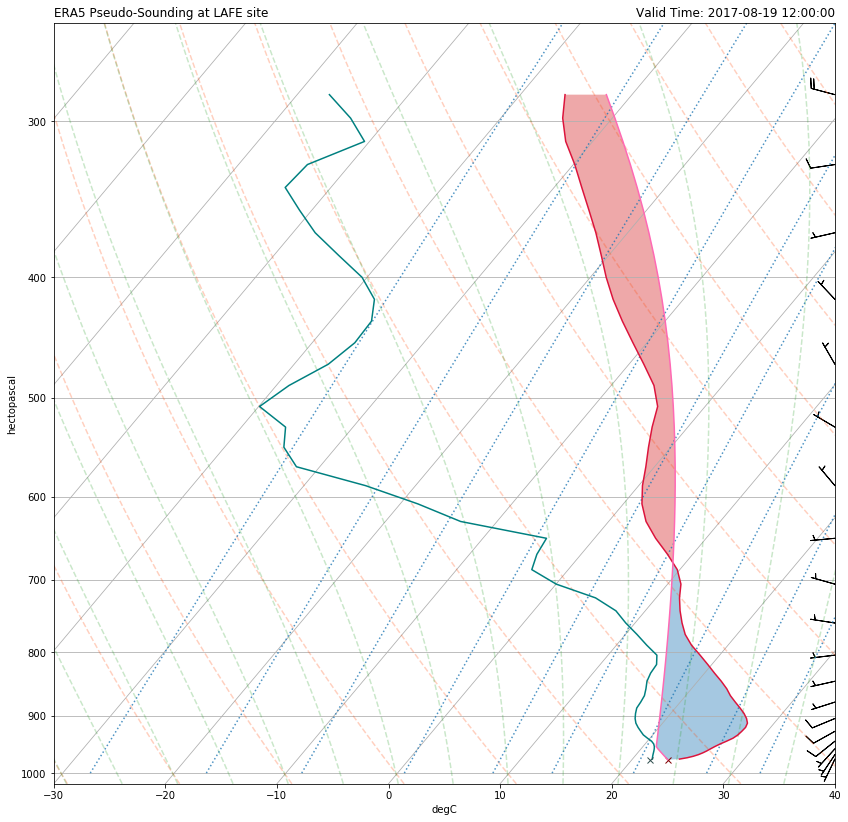

LCL: 166.4088406617337 meter 95290.70836816098 pascal 294.371084350111 kelvin


NameError: name 's_cape_e' is not defined

In [12]:
# Change default to be better for skew-T
fig = plt.figure(figsize=(14, 14))

# Initiate the skew-T plot type from MetPy class loaded earlier
skew = SkewT(fig, rotation=40)

# Plot the data using normal plotting functions, in this case using
# log scaling in Y, as dictated by the typical meteorological plot
skew.plot(ml_p.to('hectopascal'), ml_t.to('degC'), 'crimson')
skew.plot(ml_p.to('hectopascal'), ml_td.to('degC'), 'teal')
skew.plot(sfc_p.to('hectopascal'), sfc_t.to('degC'), color='maroon', marker='x')
skew.plot(sfc_p.to('hectopascal'), sfc_td.to('degC'), color='darkslategrey', marker='x')

skew.plot(mls_p.to('hectopascal'), np.flip(mls_parcel).to('degC'), 'hotpink')
skew.plot_barbs(ml_p[::3].to('hectopascal'), ml_u[::3], ml_v[::3], y_clip_radius=0.03)

# Set some appropriate axes limits for x and y
skew.ax.set_xlim(-30, 40)
skew.ax.set_ylim(1020, 250)

# Shade areas of CAPE and CIN
skew.shade_cin(mls_p.to('hectopascal'), mls_t.to('degC'), np.flip(mls_parcel).to('degC'))
skew.shade_cape(mls_p.to('hectopascal'), mls_t.to('degC'), np.flip(mls_parcel).to('degC'))

# Add the relevant special lines to plot throughout the figure
skew.plot_dry_adiabats(t0=np.arange(233, 533, 10) * units.K,
                       alpha=0.25, color='orangered')
skew.plot_moist_adiabats(t0=np.arange(233, 400, 5) * units.K,
                         alpha=0.25, color='tab:green')
skew.plot_mixing_lines(p=np.arange(1000, 99, -20) * units.hPa,
                       linestyle='dotted', color='tab:blue')

# Add some descriptive titles
plt.title('ERA5 Pseudo-Sounding at LAFE site', loc='left')
plt.title('Valid Time: {}'.format(dt), loc='right')

plt.show()
#print("EL:",s_el_p, s_el_t)
print("LCL:",s_lcl_z, s_lcl_p, s_lcl_t)
print("CAPE:",s_cape,s_cape_e)
print("CIN:",s_cin)
print("PW:",s_pw,s_pw_e)



Red is CAPE area, blue is CIN; surface values are 'x'.